# Data Exploration
<p>
    This notebook should contain preliminary data exploration and graphing of the data set.
</p>
<p>
    Last modified 4/19/18 by Kate Baumli
</p>

In [69]:
import pandas as pd
import numpy as np
import re
import nltk
import math
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import gender_guesser.detector as gender
from sklearn.cluster import KMeans
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
nltk.download('stopwords')
import os
import random

from sklearn.feature_extraction import text
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

[nltk_data] Downloading package stopwords to /home/humble-
[nltk_data]     fool/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

First load up the data. Note this data was cleaned using clean.sh. We dropped NaNs, ran sentiment scores on polarity and subjectivity, removed nonwords, punctuation, and symbols from the transcripts and placed them in the column "clean_transcripts"

In [2]:
filepath = '../data/kaggle-data/'
filename = 'merged_data.csv'
data = pd.read_csv(filepath + filename)
# drop extra index columns
data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop('Unnamed: 0.1', axis=1,inplace=True)
data.drop('Unnamed: 0.1.1', axis=1,inplace=True)

In [3]:
# Output suppressed
#data.describe()
#data.info()
data.head()

,transcript,url,clean_transcripts,comments,description,duration,event,film_date,languages,main_speaker,...,ratings,related_talks,speaker_occupation,tags,title,url.1,views,stripped_transcripts,polarity,subjectivity
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,good morninghow are you\nlaughter\nits been gr...,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,...,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,"['good', 'morninghow', 'are', 'you', 'laughter...",0.146452,0.462051
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,"thank you so much, chrisand its truly a great ...",265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,...,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,"['thank', 'you', 'so', 'much,', 'chrisand', 'i...",0.157775,0.424101
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,"music: the sound of silence, simon & garfunkel...",124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,...,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,"['music:', 'the', 'sound', 'of', 'silence,', '...",0.136579,0.475229
3,If you're here today and I'm very happy that ...,https://www.ted.com/talks/majora_carter_s_tale...,if youre here today and im very happy that yo...,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,...,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,"['if', 'youre', 'here', 'today', 'and', 'im', ...",0.082928,0.439165
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,"about 10 years ago, i took on the task to teac...",593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,...,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,"['about', '10', 'years', 'ago,', 'i', 'took', ...",0.096483,0.450631


In [4]:
# Output suppressed, this is to check data was cleaned properly
#print(data.clean_transcripts[0]) 

Let's look at how our features are correlated:

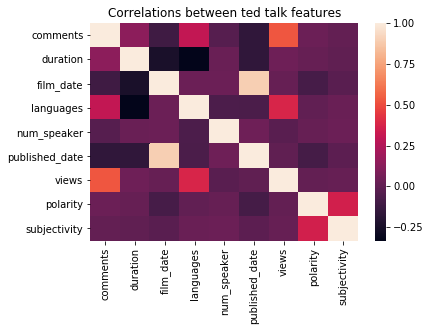

In [5]:
correlations = data.corr()
_ = sns.heatmap(correlations)
_ = plt.title('Correlations between ted talk features')
plt.show()

Nothing too shocking here. We see that publish date and film date are correlated, as would be expected. We also see that views and comments are correlated, again, no shock there.

In [6]:
# Find transcript with the most words
maxLen = 0
for row in data.itertuples():
    if len(row.clean_transcripts.split()) >= maxLen:
        maxLen = len(row.clean_transcripts.split()) 
        longestTalk = row.name
print(maxLen)
print(longestTalk)

8760
Zeynep Tufekci: Machine intelligence makes human morals more important


In [7]:
def getWords(df,removeStopWords):
    words = []
    for row in df.itertuples():
        words.extend(row.clean_transcripts.split())
    
    # Removing Stopwords ('the', 'it', 'is', 'and', etc)
    if removeStopWords:
        stopWords = set(stopwords.words('english'))
        print("Removing the stop words... ")
        
        filteredWords =[]
        for word in words: 
            if word not in stopWords:
                filteredWords.append(word)
                
        return filteredWords
    
    return words

In [8]:
def mostFrequentWords(df, numWordsDesired, descriptor='', removeStopWords=True, normalize=False):
    # This loops over all rows in the clean transcripts column and 
    # puts every word in every transcript into a list called words
    words = getWords(df,removeStopWords)
    
    descriptor2=''
    if removeStopWords:
        descriptor2 = '(excluding stop words like \'the\')'
    
    # Get counts for each word
    wordCounts = Counter(words)
    print(descriptor,'Number of unique words:',descriptor2,len(wordCounts))

    # Grab the most common words
    mostCommon = dict()
    for word, wordCount in wordCounts.most_common(numWordsDesired):
        if normalize:
            # Divide by total # of words to get percentage of words said
            mostCommon[word] = wordCount/float(len(words)) 
        else:
            mostCommon[word] = wordCount
    # Plot a histogram
    _ = plt.figure(figsize=(20,10))
    _ = sns.barplot(list(mostCommon.keys()), list(mostCommon.values()))
    title = ('The '+str(numWordsDesired)+' Most Common Words ' + descriptor2 +
             ' In All ' + descriptor +' TED Talk Transcripts')
    _ = plt.title(title)
    _ = plt.xticks(rotation=300)
    plt.show()
    
    # Return list of most common words
    return mostCommon

Removing the stop words... 
 Number of unique words: (excluding stop words like 'the') 234988


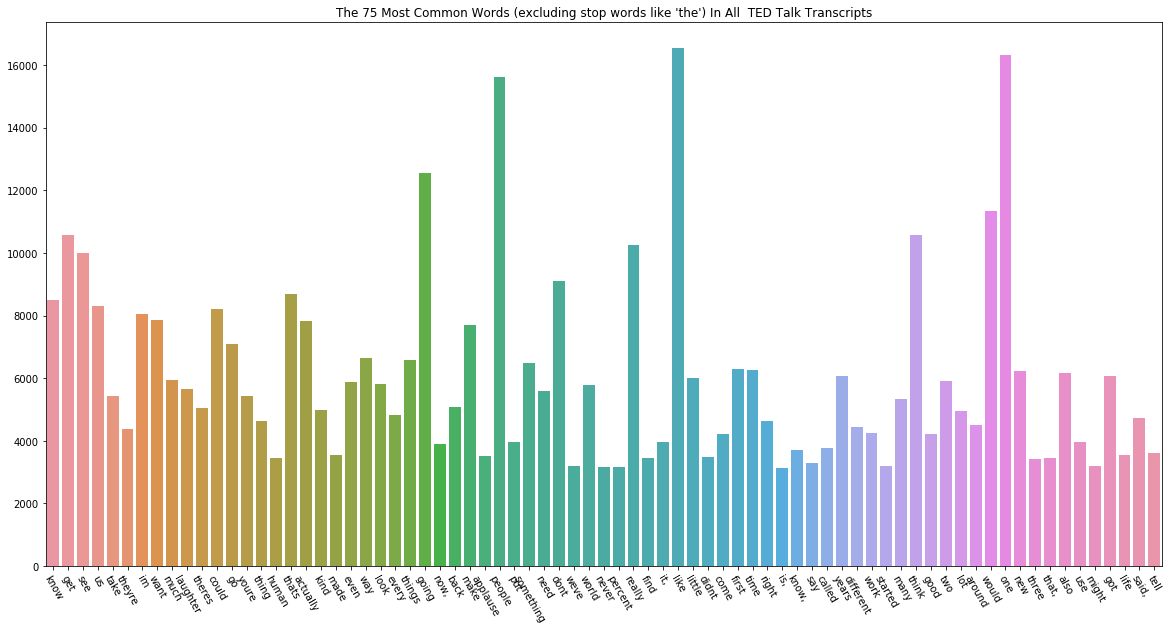

In [9]:
_ = mostFrequentWords(data,75)

### Let's break the data set into two segments based on (guessed) speaker gender.

In [10]:
genDetector = gender.Detector()
speakerNames = data.main_speaker.tolist()

speakerFirstNames = []
genders = []
for name in speakerNames:
    firstLastName = name.split(' ')
    firstName = firstLastName[0]
    speakerFirstNames.append(firstName)
    genders.append(genDetector.get_gender(firstName))
data['gender'] = genders

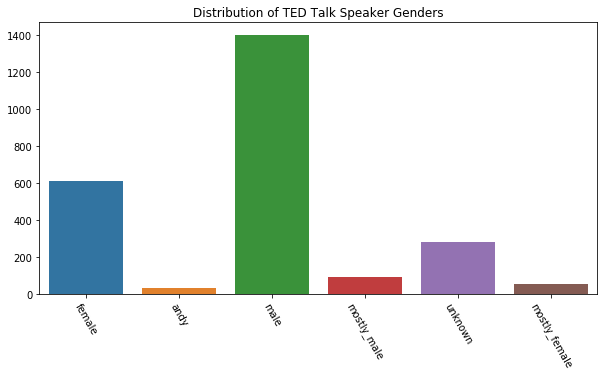

In [11]:
# Plot a histogram of genders
genderCounts = Counter(genders)
_ = plt.figure(figsize=(10,5))
_ = sns.barplot(list(genderCounts.keys()), list(genderCounts.values()))
title = 'Distribution of TED Talk Speaker Genders'
_ = plt.title(title)
_ = plt.xticks(rotation=300)
plt.show()

Let's go ahead and add the "mostly_female" names to female category and "mostly_male" names to male category.

In [12]:
for i,gender in enumerate(genders):
    if gender == 'mostly_male':
        genders[i] = 'male'
    if gender == 'mostly_female':
        genders[i] = 'female'
    if gender == 'andy':
        genders[i] = 'unknown' # No need to have 2 unknown categories if we're going to have to manually label anyways

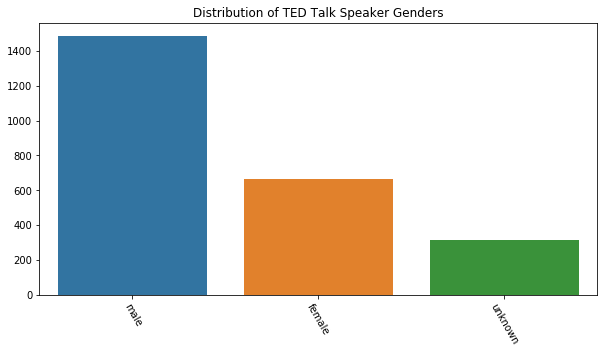

In [13]:
data['gender'] = genders
# Replot a histogram of genders
genderCounts = Counter(genders)
_ = plt.figure(figsize=(10,5))
_ = sns.barplot(list(genderCounts.keys()), list(genderCounts.values()))
title = 'Distribution of TED Talk Speaker Genders'
_ = plt.title(title)
_ = plt.xticks(rotation=300)
plt.show()

Aman went through and manualy labeled the 311 unknown gender speakers and came up with gender labels for each "unknown" labeled index:

In [14]:
maleIndexes = {21,32,35,48,58,64,78,92,102,124,130,134,135,144,154,171,175,194,222,233,249,261,270,289,317,320,324,360,371,393,415,419,449,480,482,484,485,487,512,523,553,556,570,577,583,587,591,593,594,597,599,608,624,627,632,723,732,747,761,780,781,790,797,810,837,879,880,896,897,900,905,919,957,959,962,966,979,1005,1010,1011,1018,1024,1038,1040,1081,1085,1090,1091,1100,1110,1113,1133,1137,1168,1180,1184,1198,1203,1225,1232,1235,1261,1270,1271,1272,1278,1363,1377,1383,1392,1395, 1397, 1398, 1407, 1423,1425, 1427,1437,1471,1474,1482,1505,1540,1548,1560,1583,1598,1605,1615,1640,1666,1684,1685,1706,1707,1746,1756,1766,1767,1772,1775,1782,1789,1791,1806,1814,1820,1825,1859,1872,1877,1887,1895,1927,1931,1944,1955,1972,2005,2012,2021,2042,2059,2081,2124,2159,2164,2176,2206,2223,2231,2238,2242,2247,2250,2288,2297,2300,2307,2309,2312,2338,2340,2394,2414,2418,2431,2437,2444,2450,2460}
femaleIndexes = {3,11,15,110,128,190,209,237,281,282,323,393,459,474,530,555,607,622,651,654,673,694,767,836,840,863,878,941,983,1000,1021,1027,1037,1089,1110,1149,1152,1177,1188,1189,1222,1248,1259,1275,1278,1305,1316,1332,1339,1412,1428,1451,1460,1505,1489,1495, 1512,1532,1539,1541,1562,1573,1587,1621,1626,1679,1703,1712,1721,1737,1748,1754,1761,1797,1819,1844,1856,1857,1883,1941,1945,1961,1975,1984,1992,2003,2010,2013,2049,2054,2067,2087,2088,2098,2099,2103,2112,2122,2128,2134,2157,2158,2168,2178,2193,2194,2222,2224,2257,2271,2294,2313,2325,2349,2361,2369,2375,2380,2382,2407,2419,2420,2429,2430,2455,2457}

In [15]:
for row in data.itertuples():
    # All this 'oldIndex' junk is to adjust for the 4 rows
    # we dropped after Aman labeled all of these indexes as male
    # or female. After we pass the index of each entry we dropped,
    # the index is actaully 1 less than the index aman wrote down,
    # so we add 1 to compensate.
    oldIndex = row[0]
    if row[0] > 152: 
        oldIndex += 1
    if row[0] > 574:
        oldIndex += 1
    if row[0] > 1373:
        oldIndex += 1
    if row[0] > 1922:
        oldIndex += 1
    if row.gender == 'unknown':
        if oldIndex in maleIndexes:
            data.loc[row[0],'gender'] = 'male'
        elif oldIndex in femaleIndexes:
            data.loc[row[0],'gender'] = 'female'
        else:
            print(row[0])

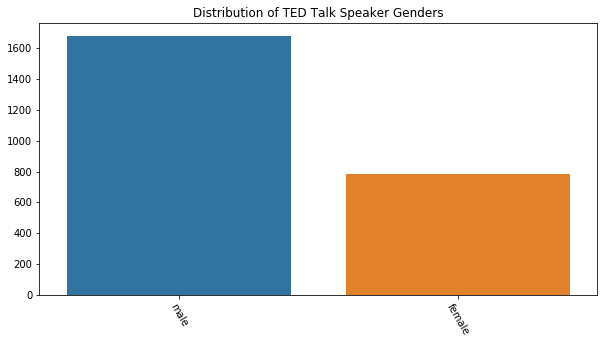

In [16]:
# Replot a histogram of genders
genderCounts = Counter(data['gender'])
_ = plt.figure(figsize=(10,5))
_ = sns.barplot(list(genderCounts.keys()), list(genderCounts.values()))
title = 'Distribution of TED Talk Speaker Genders'
_ = plt.title(title)
_ = plt.xticks(rotation=300)
plt.show()

Right off the bat we can see that about twice as many speakers are men than women(disregarding the unknown). Let's compare the average # of views of men vs women.

### Let's build a simple gender classifier on the original data with no new features.

In [17]:
def getTFIDFvectors(dataframe):
    scripts = dataframe['transcript'].tolist()
    tfidfGenerator = text.TfidfVectorizer(input= scripts, stop_words= "english")
    matrix = tfidfGenerator.fit_transform(scripts)
    return matrix

def simpleGenderClf(dataframe):
    vectors = getTFIDFvectors(dataframe)
    answers = dataframe['gender'].tolist()

    bayesClf = MultinomialNB()
    svmClf = SGDClassifier()

    #auc = make_scorer(roc_auc_score, needs_proba=True)

    bayesScores  = cross_val_score(bayesClf, vectors, answers)
    svmScores = cross_val_score(svmClf, vectors, answers)
    
    print("Bayes Accuracy Scores: ", bayesScores)
    print("SVM Accuracy Scores: ", svmScores)

originalData = data.drop(labels=['polarity','subjectivity'], axis=1)


In [18]:
print('Original Data Scores:')
simpleGenderClf(originalData)
print('Adding in polarity and subjectivity scores')
simpleGenderClf(data)

Original Data Scores:


/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default t

Bayes Accuracy Scores:  [0.68126521 0.68209501 0.68170732]
SVM Accuracy Scores:  [0.64841849 0.62362972 0.5902439 ]
Adding in polarity and subjectivity scores
Bayes Accuracy Scores:  [0.68126521 0.68209501 0.68170732]
SVM Accuracy Scores:  [0.65085158 0.61266748 0.59268293]


/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default t

In [19]:
menTED = data[data['gender'] == 'male']
womenTED = data[data['gender'] == 'female']
#print('Description of male speaker TED data:')
#menTED.describe()
#print('Description of female speaker TED data:')
#womenTED.describe()

Let's compare the frequency of words:

Removing the stop words... 
Male Speaker Number of unique words: (excluding stop words like 'the') 184337


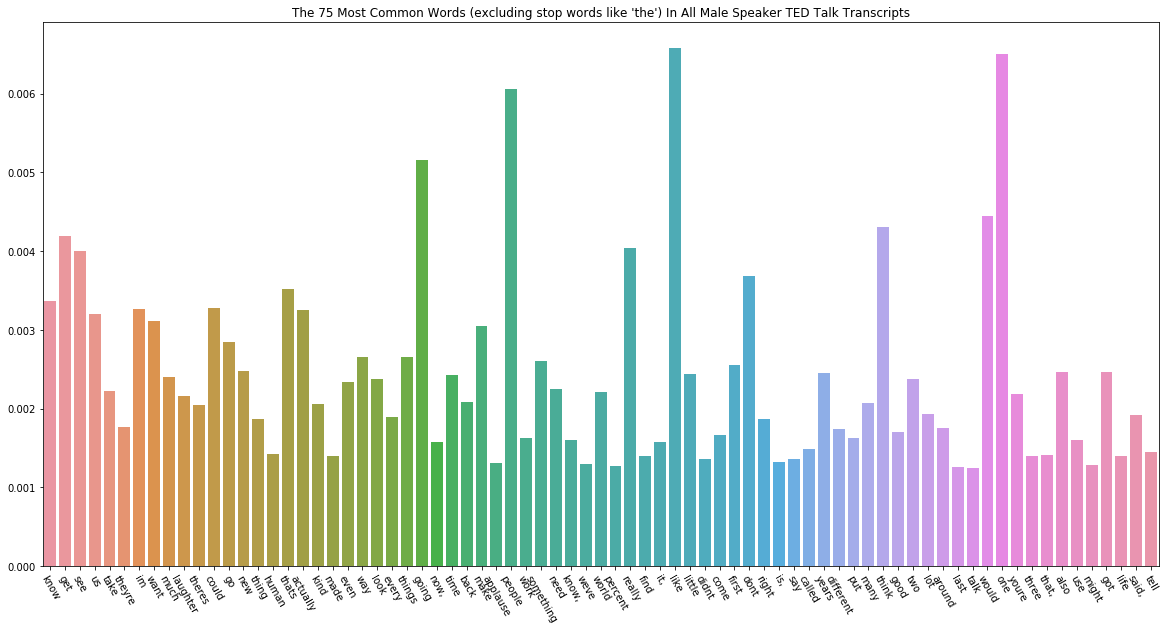

Removing the stop words... 
Female Speaker Number of unique words: (excluding stop words like 'the') 103879


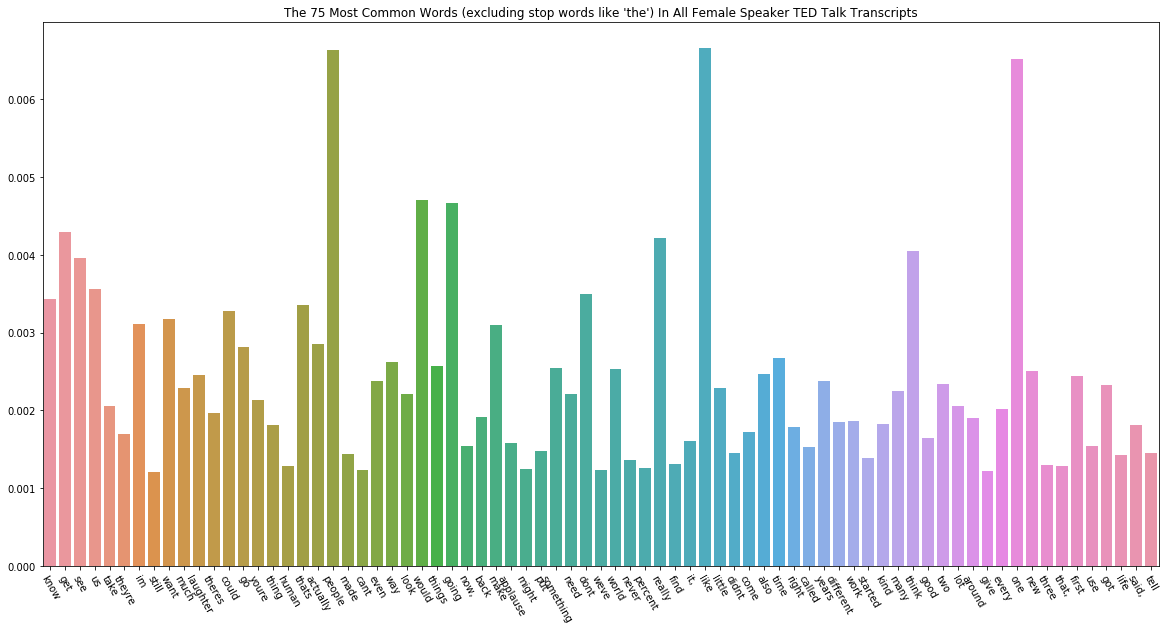

In [20]:
maleCommonWords = mostFrequentWords(menTED,75,'Male Speaker',normalize=True)
femaleCommonWords = mostFrequentWords(womenTED,75,'Female Speaker',normalize=True)

It's also interesting that men seem to pause more frequently than do women.

### Previous research on the differences of speech patterns between men and women, we have found that women are more likely to use speech qualifiers/intensifiers such as 'very','so','such','extremely','really','totally','absolutely', or 'too'. Let's look into that a little more here and compare our talks:

In [21]:
def getNormalizedGenderWordCounts():
    maleWords = getWords(menTED,removeStopWords=True)
    femaleWords = getWords(womenTED,removeStopWords=True)

    # Get counts for each word
    maleWordCounts = Counter(maleWords)
    femaleWordCounts = Counter(femaleWords)

    # Normalize counts by number of total words spoken by men 
    normalizedMaleWordCounts = {}
    for word,count in dict(maleWordCounts).items():
        normalizedMaleWordCounts[word] = count/float(len(maleWords))

    # Normalize counts by number of total words spoken by women 
    normalizedFemaleWordCounts = {}
    for word,count in dict(femaleWordCounts).items():
        normalizedFemaleWordCounts[word] = count/float(len(femaleWords))
        
    return normalizedMaleWordCounts, normalizedFemaleWordCounts

In [22]:
def menVsWomenWordCounts(wordsToCount):    
    normalizedMaleWordCounts, normalizedFemaleWordCounts = getNormalizedGenderWordCounts()
    maleCount = 0
    for word,count in normalizedMaleWordCounts.items():
        if word in wordsToCount:
            maleCount += count
        
    femaleCount = 0
    for word,count in normalizedFemaleWordCounts.items():
        if word in wordsToCount:
            femaleCount += count
            
    return maleCount, femaleCount

In [23]:
intensifiers = ['very','so','such','really','totally','too']
maleIntensifierCount, femaleIntensifierCount = menVsWomenWordCounts(intensifiers)

print('Percentage of intensifier words for men:  ',maleIntensifierCount)
print('Percentage of intensifier words for women:',femaleIntensifierCount)

Removing the stop words... 
Removing the stop words... 
Percentage of intensifier words for men:   0.0042381947331967314
Percentage of intensifier words for women: 0.004413554602993959


Some other studies https://www.washingtonpost.com/news/the-intersect/wp/2016/05/28/these-are-the-words-most-associated-with-men-and-women-according-to-facebook-status-updates/?noredirect=on&utm_term=.54981ab1318a have shown that women tend to use words that are more "warm and agreeable"

In [28]:
uncertainty = ['um','uh','-']
maleUncertaintyCount, femaleUncertaintyCount = menVsWomenWordCounts(uncertainty)
print('Percentage of uncertainty words for men:  ',maleUncertaintyCount)
print('Percentage of uncertainty words for women:',femaleUncertaintyCount)

Removing the stop words... 
Removing the stop words... 
Percentage of uncertainty words for men:   1.4456231734551204e-05
Percentage of uncertainty words for women: 7.730743362512595e-06


Flagging um and uh might prove useful in differentiating between genders

In [29]:
warmAndAgreeable = ['family','friends','wonderful','blessed','amazing','loving','husband','thankful']
maleWarmAgreeableCount, femaleWarmAgreeableCount = menVsWomenWordCounts(warmAndAgreeable)

print('Percentage of warm and agreeable words for men:  ',maleWarmAgreeableCount)
print('Percentage of warm and agreeable words for women:',femaleWarmAgreeableCount)

Removing the stop words... 
Removing the stop words... 
Percentage of warm and agreeable words for men:   0.0015046045989320891
Percentage of warm and agreeable words for women: 0.0018012632034654344


'Warm and agreeable' words could be useful to flag!

In [30]:
coldHearted = ['kill','kills','dead','killing','die','swear','dead','murder']
maleColdHeartedCount, femaleColdHeartedCount = menVsWomenWordCounts(coldHearted)

print('Percentage of cold hearted words for men:  ',maleColdHeartedCount)
print('Percentage of cold hearted words for women:',femaleColdHeartedCount)

Removing the stop words... 
Removing the stop words... 
Percentage of cold hearted words for men:   0.0005597452927618225
Percentage of cold hearted words for women: 0.0007009207315344753


'Cold hearted' words seem to be slightly more frequent for women than men. 

In [31]:
rational = ['opinion','opinions','logic','logical','based','political','fact','moral','beliefs']
maleRationalCount, femaleRationalCount = menVsWomenWordCounts(rational)
print('Percentage of rational words for men:  ',maleRationalCount)
print('Percentage of rational words for women:',femaleRationalCount)

Removing the stop words... 
Removing the stop words... 
Percentage of rational words for men:   0.0014618141529978176
Percentage of rational words for women: 0.0015190910707337246


Let's compare speed of speech of men and women. 

In [32]:
WPM = []
for row in data.itertuples():
    minutes = row.duration/float(60) # Duration is in seconds
    numWords = len(row.clean_transcripts.split(' '))
    WPM.append(numWords/float(minutes))
data['WPM'] = WPM

In [33]:
def compareGenders(feature):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    # violin plots in seaborn require 2 catagorical variables ('x' and 'hue'). We use 'gender' for hue.
    placeholder = np.zeros(len(data[feature].values))
    _ = sns.violinplot(x=placeholder, y=data[feature], hue=data.gender,split=True,ax=axes[0], palette='bright')
    _ = axes[0].set_title('Comparing Distribution of '+feature+ ' by Gender')
    _ = sns.boxplot(x=placeholder,y=data[feature],hue=data.gender, ax = axes[1])
    _ = axes[1].set_title('Comparing Distribution of '+feature+ ' by Gender')
    plt.show()

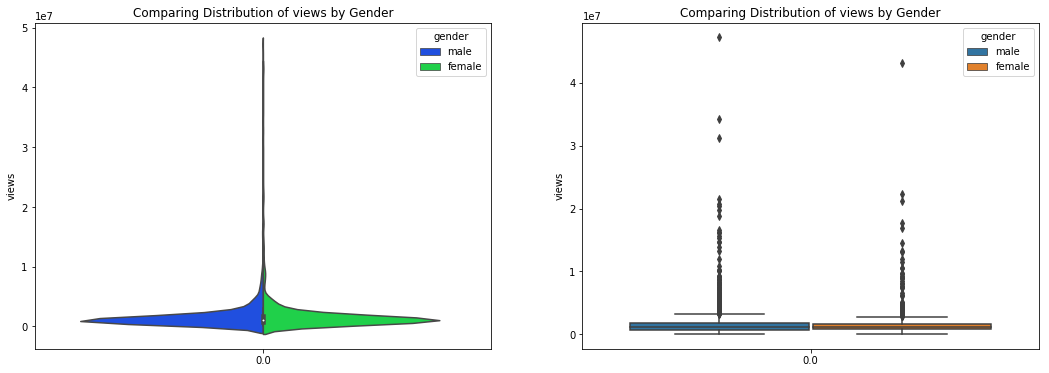

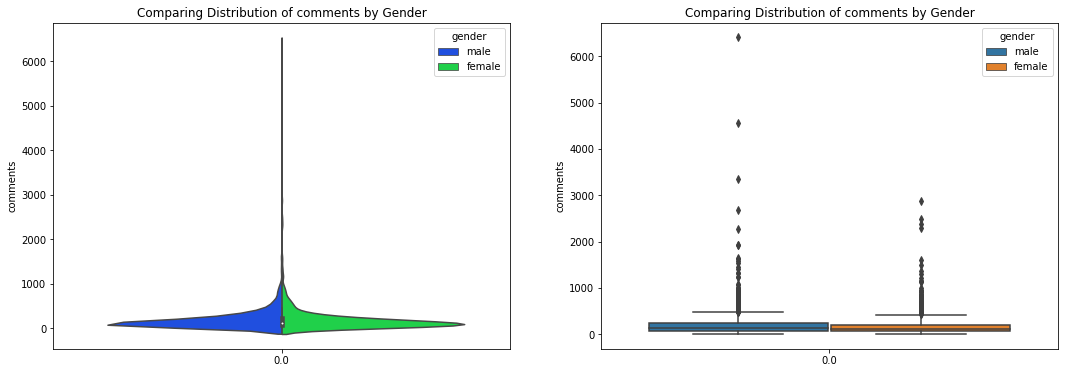

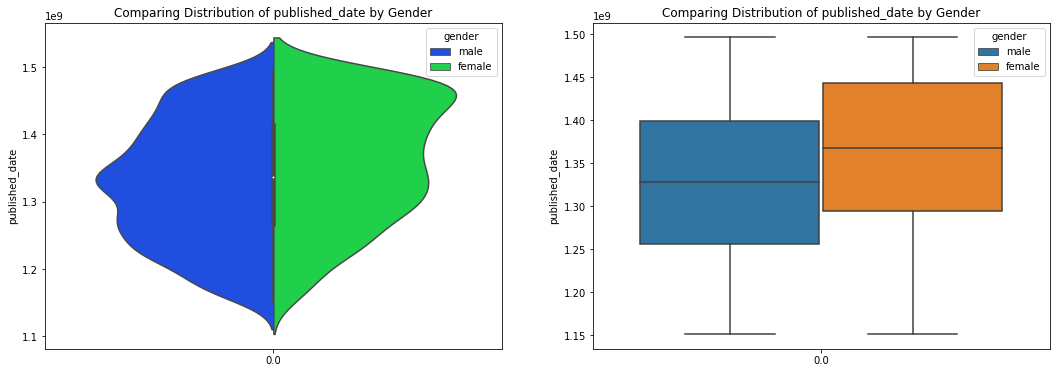

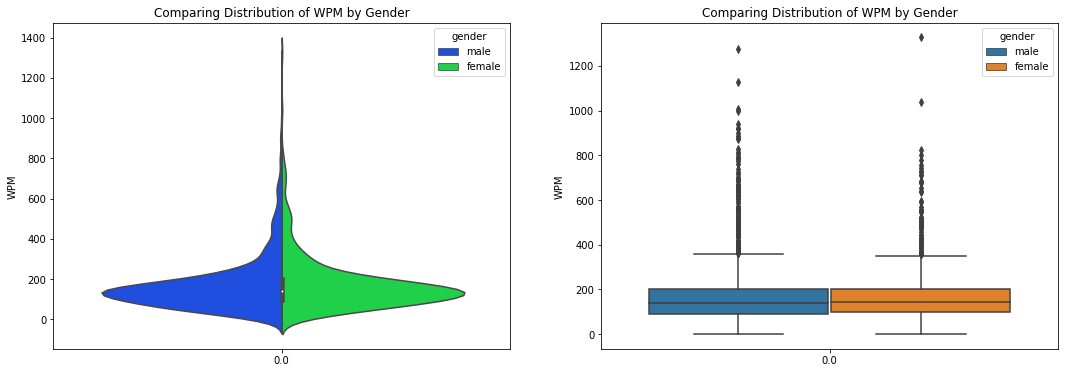

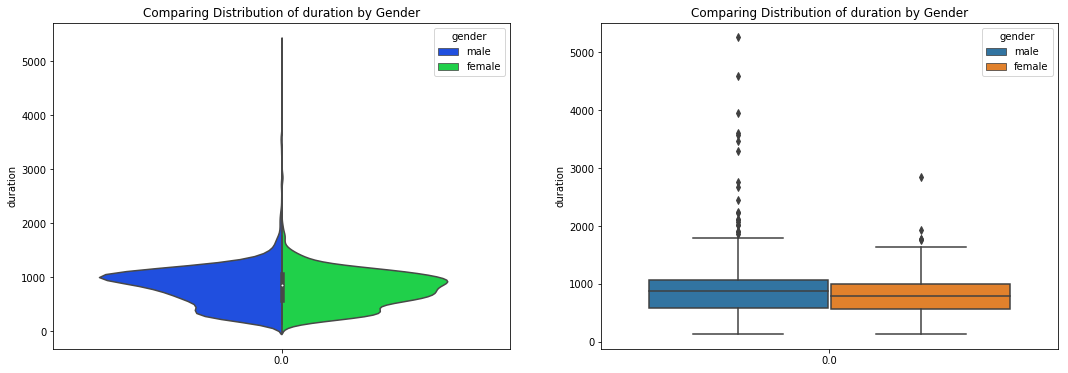

In [34]:
compareGenders('views')
compareGenders('comments')
compareGenders('published_date')
compareGenders('WPM')
compareGenders('duration')

Duration and published date seem to correlate with gender based on the plots above. These features could be useful to highlight when building a gender classifier. 

Now let's compare the amount of (laughter) and (applause) recieved by men and women normalized by the length of the talk.

In [35]:
laughter = []
applause = []
for row in data.itertuples():
    words = row.clean_transcripts.split() # Not the cleaned transcripts because those take out the () around laughter and applause
    laughCount = 0
    applauseCount = 0
    for word in words:
        if word == 'laughter':
            laughCount += 1
        if word == 'applause':
            applauseCount += 1
    laughter.append(laughCount/float(len(words))) # laugh to words ratio
    applause.append(applauseCount/float(len(words))) # applause to words ratio

data['laughter_ratio'] = laughter
data['applause_ratio'] = applause

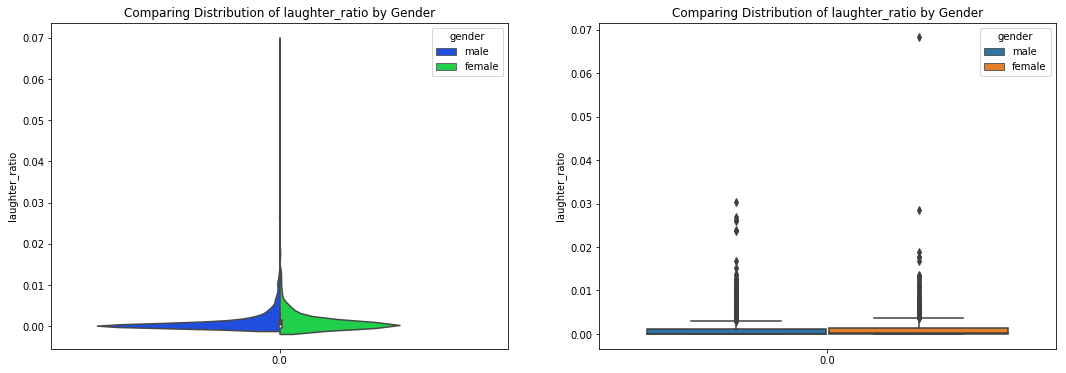

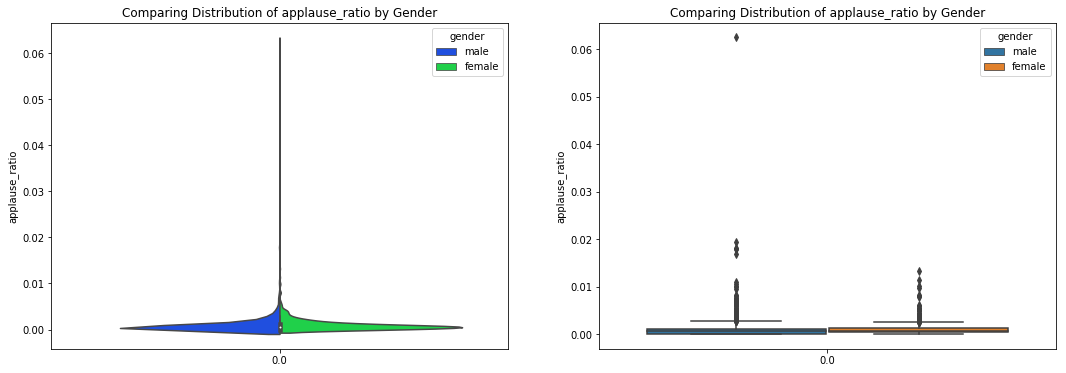

In [36]:
compareGenders('laughter_ratio')
compareGenders('applause_ratio')

In looking at this, we discovered some transcripts that did not have the words of the speeech besides (applause) and (laughter). We went back and removed these from the set so they are not shown here.  

Removing the stop words... 
Removing the stop words... 


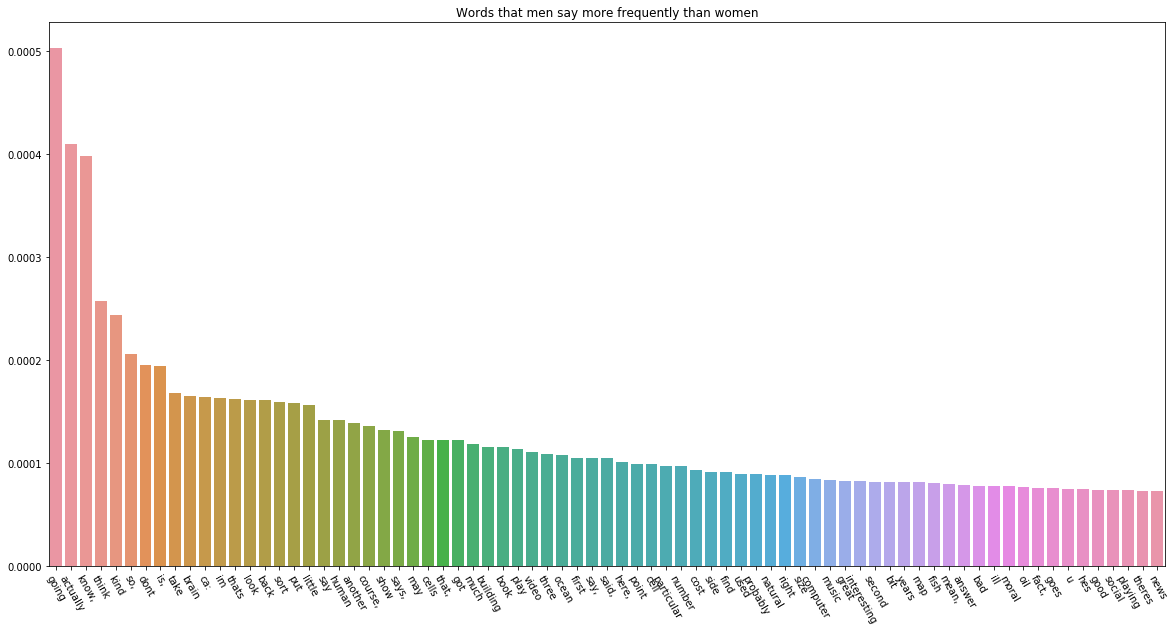

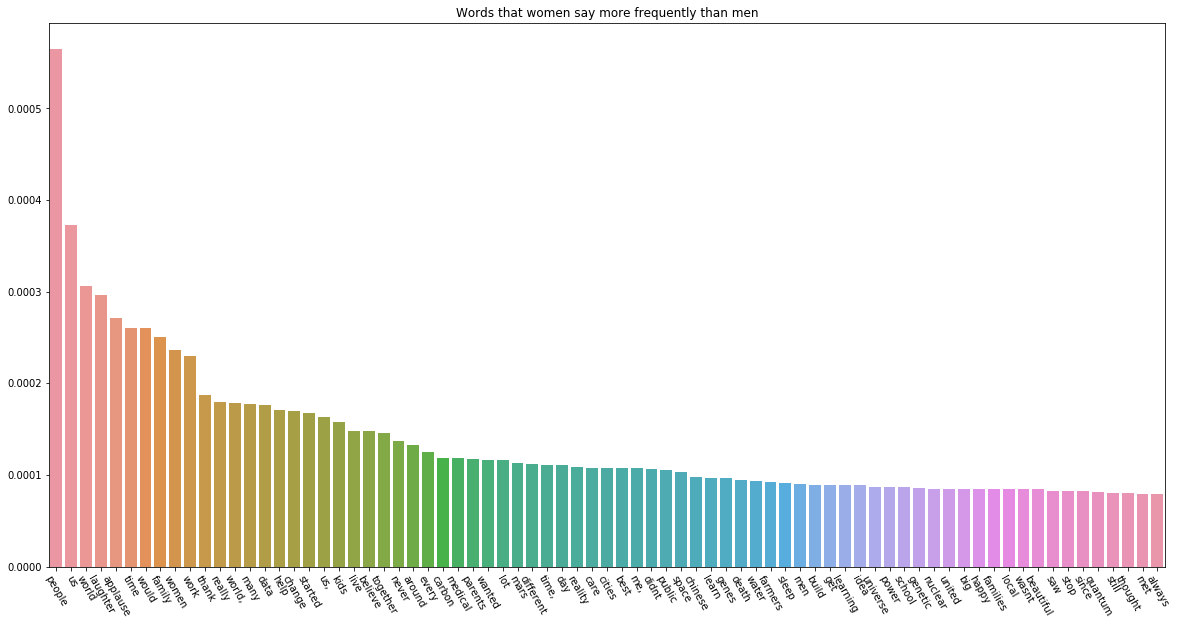

In [37]:
def sortWordsByGenderGap():
    normalizedMaleWordCounts, normalizedFemaleWordCounts = getNormalizedGenderWordCounts()
    doneWords = set() # To keep track of the words we've done
    genderGap = dict() # To record differnce by gender of word frequency
    
    # Loop through all male words and get gender difference
    for word, maleCount in normalizedMaleWordCounts.items():
        doneWords.add(word)
        if word in normalizedFemaleWordCounts.keys():
            femaleCount = normalizedFemaleWordCounts[word]
        else:
            femaleCount = 0
        diff = maleCount-femaleCount
        genderGap[word] = diff
        
    for word, femaleCount in normalizedFemaleWordCounts.items():
        # We already went through every word in male dictionary, if we reach it here, word count for men is 0,
        # therefore the difference between men and women frequencies for this word is just the women frequency.
        if word not in doneWords:
            genderGap[word] = -femaleCount 
    sortedMenFirst = sorted(genderGap.items(), key=operator.itemgetter(1),reverse=True)
    sortedWomenFirst = sorted(genderGap.items(), key=operator.itemgetter(1),reverse=False)
    
    # Plot a histogram of words that men say more frequently than women 
    _ = plt.figure(figsize=(20,10))
    _ = sns.barplot(list(dict(sortedMenFirst[0:75]).keys()), list(dict(sortedMenFirst[0:75]).values()))
    title = ('Words that men say more frequently than women')
    _ = plt.title(title)
    _ = plt.xticks(rotation=300)
    plt.show()
    
    # Plot a histogram of words that women say more frequently than men 
    _ = plt.figure(figsize=(20,10))
    _ = sns.barplot(list(dict(sortedWomenFirst[0:75]).keys()), np.fabs(list(dict(sortedWomenFirst[0:75]).values())))
    title = ('Words that women say more frequently than men')
    _ = plt.title(title)
    _ = plt.xticks(rotation=300)
    plt.show()
    return sortedMenFirst
_ = sortWordsByGenderGap()

Flagging some times of these high frequency difference words may help our classifier learn better!

### Now that we've explored into the differences of men and women's speech patterns, let's create some new features based off of what we haved learned!
The plan is to 
<br>1) Flag high frequency words
<br>2) Flag word categories that seemed to make a difference when explored above
    <br>a) warm and agreeable
        b) cold hearted
        c) uncertainty
        d) 
<br>3) Flag pauses ('-')
<br>4) Flag duration
<br>5) Flag date published < certain date and > certain date

#### 1) Flag high frequency words
#### 2) Flag word categories
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) warm and agreeable
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) uncertainty
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c) cold hearted
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; d) intensifiers

In [56]:
# 1) 
highMaleFreq = ['going','actually','know,','think','kind']
highFemaleFreq = ['people','us','world','laughter','applause']
highFreqMaleWordCounts = []
highFreqFemaleWordCounts = []

# 2) 
warmAgreeable = ['family','friends','wonderful','blessed','amazing','loving','husband','thankful']
uncertainty = ['um','uh']
intensifiers = ['very','so','such','really','totally','too']
coldHearted = ['kill','kills','dead','killing','die','swear','dead','murder']
warmAgreeableCounts = []
uncertaintyCounts = []
intensifierCounts = []
coldHeartedCounts = []

for row in data.itertuples():
    words = row.clean_transcripts.split()
    talkMaleFreqCount = 0
    talkFemaleFreqCount = 0
    talkWarmAgreeableCount = 0
    talkColdHeartedCount = 0
    talkIntensifierCount = 0
    talkUncertaintyCount = 0
    for word in words:
        if word in highMaleFreq:
            talkMaleFreqCount +=1
        if word in highFemaleFreq:
            talkFemaleFreqCount +=1
            
        if word in warmAgreeable:
            talkWarmAgreeableCount +=1
        if word in coldHearted:
            talkColdHeartedCount +=1
        if word in intensifiers:
            talkIntensifierCount +=1
        if word in uncertainty:
            talkUncertaintyCount +=1
            
    highFreqMaleWordCounts.append(talkMaleFreqCount/float(len(words)))
    highFreqFemaleWordCounts.append(talkFemaleFreqCount/float(len(words)))
    
    warmAgreeableCounts.append(talkWarmAgreeableCount/float(len(words)))
    uncertaintyCounts.append(talkUncertaintyCount/float(len(words)))
    intensifierCounts.append(talkIntensifierCount/float(len(words)))
    coldHeartedCounts.append(talkColdHeartedCount/float(len(words)))
    
     # 3) 
    rawWords = row.transcript.split()
    pauseCounts = []
    for word in rawWords:
        pauseCount = 0
        if word == '-':
            pauseCount += 1
        pauseCounts.append(pauseCount/float(len(rawWords)))
            
    
data['commonMaleWordFreq'] = highFreqMaleWordCounts
data['commonFemaleWordFreq'] = highFreqFemaleWordCounts

data['warmAgreeable'] = warmAgreeableCounts
data['uncertainty'] = uncertaintyCounts
data['intensifiers'] = intensifierCounts
data['coldHearted'] = coldHeartedCounts

data['pauses'] = pauseCounts
data.head()

ValueError: Length of values does not match length of index

In [ ]:
compareGenders('commonMaleWordFreq')
compareGenders('commonFemaleWordFreq')

compareGenders('warmAgreeable')
compareGenders('intensifiers')
compareGenders('uncertainty')
compareGenders('coldHearted')

#### 3) Flag pauses

#### Trying to cluster the data

In [87]:
## This method generates k number of clusters specified in the function call. default value is 2.
def genClusters(dataFrame, k=2):
    vector_matrix = getTFIDFvectors(dataFrame)
    means = KMeans(k, random_state =0)
    result = means.fit_predict(vector_matrix)
    result_1 = means.fit_transform(vector_matrix)
    plt.scatter(result_1[:,0],result_1[:,1],c =result, cmap = 'autumn')
    plt.title("Basic Clustering without any transformation on the data")
    
    

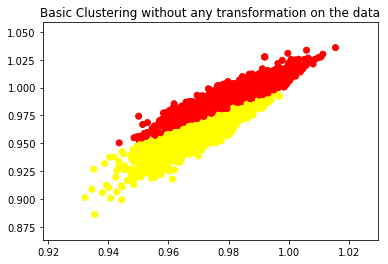

In [88]:
genClusters(data)

In [90]:
def genClusters_svd(dataFrame, k =2, n_comp = 5):
    vector_matrix = getTFIDFvectors(dataFrame)
    means = KMeans(k, random_state = 0)
    # doing TruncatedSVD on the matrix with specified number of components. PCA isn't supported on sparse matrices
    tSVD = TruncatedSVD(n_components = n_comp)
    transformed_vector_matrix = tSVD.fit_transform(vector_matrix)
    
    # Running Kmeans clustering algorithm on transformed data
    result = means.fit_predict(transformed_vector_matrix)
    result_1 = means.fit_transform(transformed_vector_matrix)
    plt.scatter(result_1[:,0],result_1[:,1],c =result, cmap = 'autumn')
    plt.title("Clustering the data after dimensionality reduction")

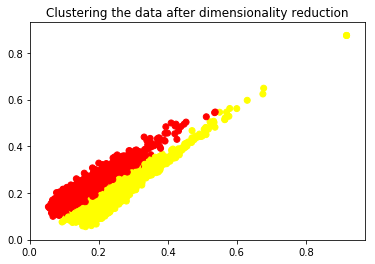

In [92]:
genClusters_svd(data,n_comp = 10)